<a href="https://colab.research.google.com/github/msarvestani/Sinusoidal_Transform/blob/main/Map_Formation_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction and Instructions

This interactive notebook contains the model in Figure 3 of Sedigh-Sarvestani et al.

V2 is modeled, using an elastic-net, as consisting of 600 point ‘neurons’, each at a particular location on a cortical sheet and a receptive field (RF) defined by its azimuth and elevation in the visual field (VF). Retinotopic maps are produced by color-coding the sheet by the RF azimuth or elevation value of each neuron (Figure 3A, ‘Cortical Maps’). 

The premise is to create a topographic map by minimizing a cost function that trades off uniform visual field coverage with biologically inspired penalties applied to the cortical map. These penalties 'constrain' the mapping of the RFs according to their layout on the cortex and include: c1) smoothness c2) vertical meridian at area boundary and c3) relatively round RFs.

Elastic nets implementation with tensorflow modified from Hsin-Hao Yu @ https://github.com/hsinhaoyu/DM_Retinotopy, who generously shared his code.

To run this notebook: Runtime -> Run all. Alternatively you can run each cell by clicking the play button on the top left. Cells must be run in order.

If you edit the code, the easiest way to ensure the edits get processed correctly is by restarting the notebook: Runtime -> Restart and run all.

For questions contact:
msarvestani@gmail.com\
Madineh Sedigh-Sarvestani @MPFI, 2020.

# Setup

In [2]:
#@title Imports
!pip install celluloid #for saving movies

import tensorflow.compat.v1 as tf #use compatibility mode since colab runs tf v>1
tf.disable_v2_behavior()
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
from scipy.special import erfinv,erf

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
#@title Parameters
# define parameters for area map, visual field, cost-function, and learning rate

# map_h is the side that has a boundary
# this geometry is defined by neighborhood()
# for example, (h, w) = (5, 3)
# index:
#    x 0 5 10
#    x 1 6 11
#    x 2 7 12
#    x 3 8 13
#    x 4 9 14
# x is boundary

#target/input RFs
fov_shape= 'circle' #'circle','square'
ecc0 = 0.1 #min eccentricity
ecc1 = 15 #define max eccentricity in degrees for all shapes


if fov_shape in 'circle':
  vm_len=ecc1
elif fov_shape in 'square':
  square_height=ecc1
  vm_len = square_height/2 


### cortex
total_size = 600
ar = 2 #aspect ratio of cortical area
unit = np.power(total_size,1/(ar+1))
map_w = int(np.round(np.sqrt(total_size/ar)))
map_h= int(np.round(ar*map_w))

#number of input RFs in target visual field
n_prototypes    = int(np.round(1*map_h*map_w))#number of points in target visual field

### cost-function parameters
# b0 - weight for main cost function (defined as 1)
# b1 - the weight for points inside the map (smoothness)
# b2 - the weight for map boundary (continuity across areas). 
# b3 - the weight for maintaining non-stretched RFs
b0 = 1
b1 = 0.03
b2 = 0.03
b3 = 0.03

#learning rules
eta0 = 0.09   # how current gradient influencs next move, default 0.09
m = 0.9         # how past step influences next move, default 0.9

# add small mount of noise to the prototypes, which might give the solution some variations
prototype_noise = True

#initial condition
init = 'random' #choose 'vm' or 'random'

#number of iterations
num_iter = 1600

#annealing factor
k = 100


In [4]:
#@title Helper Functions

#generate VM boundary at the left border of V2 cortical slab
def generate_v2_boundary(vm_len, div):
    zz = []
    for x in np.linspace(-vm_len, vm_len, div):
        coords =  [0.0,x]
        zz.append(coords)
    return np.array(zz)

###generate landmarks on the visual field
def spiral(c, r0, r1, n, shuffleP=True):
    """
        Make a spiral with n points.
        the distance from these points to (0, 0) ranges from r0 to r1
        the density of the dots falls off accoridng to r^c, where r is the distance to (0, 0)
        c should be a negative number
        returns a numpy array
    """
    def f(r):
        return np.sqrt(np.power(r, 1.0-c)/(1.0-c))

    n0 = np.power(r0 * r0 * (1.0-c), 1.0/(1.0-c))
    n1 = np.power(r1 * r1 * (1.0-c), 1.0/(1.0-c))

    lst = []
    for k in range(1, n+1):
        d = f( (n1-n0)/(n-1)*k + n0-(n1-n0)/(n-1) )
        theta = 3.1415926 * (3.0 - np.sqrt(5.0)) * (k-1.0)
        x = d * np.cos(theta)
        y = d * np.sin(theta)
        lst.append((x,y))
    res = np.asarray(lst, dtype=np.float64)
    if shuffleP:
        np.random.shuffle(res)
    return res

def generate_landmarks_spiral(c, r0, r1, n, noise=False):
   # x0 = generate_landmarks(magnification, ecc0, ecc1, n_prototypes, noise=prototype_noise)

    # generate landmarks on a hemifield
    # returns a numpy array

    # generate twice as many points because spiral() covers the entire visual field
    pts = spiral(c, r0, r1, 2*n)

    # boolean array, find those that are in the right hemifield
    pts_idx = (pts[:, 0] >= -0.0)
    #pts_idx = np.logical_and(pts[:, 0] >= 0, pts[:,1]>=0) %upper right hemifield

    # make a mask array
    pts_idx = np.stack([pts_idx, pts_idx])
    pts_idx = np.transpose(pts_idx)

    # keep points whose x coordinate is larger or equal to 0
    zz = np.extract(pts_idx, pts)
    # but since the extracted is flattend, I have to reshape it
    zz = zz.reshape([int(zz.shape[0]/2), 2])

    if noise:
        zz = zz + np.random.normal(0.0, 0.1, zz.shape)

    return zz


def generate_landmarks_random(c, r0, r1, n, noise=False):

    # generate landmarks on a hemifield
    # returns a numpy array
    
    vsize = n
    R = r1
    phi = np.random.random(size=vsize) * np.pi
    r = np.random.random(size=vsize) * R 
    #r = np.sqrt(np.random.random(size=vsize) * R) #taking the sqrt corrects small radius non-uniformities
    # transform
    yyy = r * np.cos(phi)
    xxx = r * np.sin(phi)
    x02=(np.asarray([xxx,yyy])).T
    
    return x02

def generate_landmarks_square(square_height, n):    
    x = (np.linspace(0,square_height,int(np.sqrt(n))))
    y=  (np.linspace(-square_height/2,square_height/2,int(np.sqrt(n))))
    xx,yy = np.meshgrid(x,y,sparse=True)
    xx = xx.reshape((np.prod(xx.shape),))
    yy = yy.reshape((np.prod(yy.shape),))
    points = []
    for x in xx:
       for y in yy:
           random_point = [x, y]
           points.append(random_point)
    points_array = np.asarray(points)
    return points_array

def generate_landmarks_spiral_square(g_ell_height,g_ell_width,c,r0,r1,n):

    zz=generate_landmarks_spiral(c, r0, r1, n, noise=False)

    #define perimeter of elllipse
    g_ell_center = (0, -g_ell_height/2.0)
    g_square = patches.Rectangle(g_ell_center, g_ell_height,  g_ell_height)

    points_array=[]
    for point in zz:
      if g_square.contains_point(point, radius=0):
          points_array.append(point)
      
    points_array=np.asarray(points_array)
    return points_array

def neighborhood(h, w):
    """
        numbers {0...h*w-1} arranged in a hxw grid, produce a list of neighboring numbers.
        The ith element of the list is a list of numbers that neighbor i
    """
    # this line defines how the geometry is coded
    # for (h, w) = (4, 2)
    # 0 4
    # 1 5
    # 2 6
    # 3 7
    x = np.transpose(np.array(range(h*w)).reshape([w, h]))
    lst = []
    for i in range(w):
        for j in range(h):
            neighbors = []
            for ii in [-1,0, 1]:
                for jj in [-1,0, 1]:
                    if (i+ii>=0) and (i+ii<w) and (j+jj>=0) and (j+jj<h):
                        neighbors.append(x[j+jj,i+ii])
            lst.append(neighbors)
    return lst

def neighborhood_x(h, w):
    """
        numbers {0...h*w-1} arranged in a hxw grid, produce a list of neighboring numbers.
        The ith element of the list is a list of numbers that neighbor i
    """
    # this line defines how the geometry is coded
    # for (h, w) = (4, 2)
    # 0 4
    # 1 5
    # 2 6
    # 3 7
    x = np.transpose(np.array(range(h*w)).reshape([w, h]))
    lst = []
    for i in range(w):
        for j in range(h):
            neighbors = []
            for ii in [0]:
                for jj in [-3,-2,-1,0, 1,2,3]:
                    if (i+ii>=0) and (i+ii<w) and (j+jj>=0) and (j+jj<h):
                        neighbors.append(x[j+jj,i+ii])
            lst.append(neighbors)
    return lst

def neighborhood_y(h, w):
    """
        numbers {0...h*w-1} arranged in a hxw grid, produce a list of neighboring numbers.
        The ith element of the list is a list of numbers that neighbor i
    """
    # this line defines how the geometry is coded
    # for (h, w) = (4, 2)
    # 0 4
    # 1 5
    # 2 6
    # 3 7
    x = np.transpose(np.array(range(h*w)).reshape([w, h]))
    lst = []
    for i in range(w):
        for j in range(h):
            neighbors = []
            for ii in [-3,-2,-1,0, 1,2,3]:
                for jj in [ 0]:
                    if (i+ii>=0) and (i+ii<w) and (j+jj>=0) and (j+jj<h):
                        neighbors.append(x[j+jj,i+ii])
            lst.append(neighbors)
    return lst


def make_mask(h, w, neighbors):
    x = np.zeros([h*w, h*w], dtype=np.float64)
    for i in range(h*w):
        for j in neighbors[i]:
            x[i, j] = 1.0
    return x

def make_boundary_mask(n):
    """
        n: numer of elements on the boundary
        return a n*n array
    """
    x = np.zeros([n, n], dtype=np.float64)
    for i in range(n):
        for j in [-1, 0, 1]:
            if (i+j)>=0 and (i+j)<n:
                x[i, i+j] = 1.0
    return x

def initial_condition_random(h, w, x):
    """
        initialze a cortical map of the size [map_w * map_h]
        each point on the map is randomly assigned to prototypes on the visual field (x) with some added noise
    """
    map_size = h * w

    np.random.seed(seed=1234)
    idx = np.random.randint(x.shape[0], size = map_size)
    y = x[idx, :] # randomly sample from x with replacement
    n = np.random.normal(0.0, 1.0, y.shape) 
    return y + n


def initial_condition_vm(h, w, x):
    """
        initialze a cortical map of the size [map_w * map_h]
        each point on the map is randomly assigned to prototypes on the visual field (x) with some added noise
    """
    map_size = h * w

    np.random.seed(seed=1234)
    idx = np.sort(np.random.randint(x.shape[0], size = map_size))
    y = x[idx,:]
    y[:,1] = np.sort(x[idx,1]).reshape(-1,h,order='F').ravel() #sort elevation
    y[:,0] = 0 #set azimuth to 0
    n = np.random.normal(0.0, 1.0, y.shape) 
    return y + n

In [5]:
#@title Plotting Functions
def plot_output(zz,map_w,map_h,ecc1,x0,fov_shape):
    zz_cortex2=(np.reshape(zz,(map_w,map_h,2)))

    fig,axs = plt.subplots(1,4)
    pos0=axs[0].imshow(zz_cortex2[:,:,0].T,origin='lower',cmap='RdYlBu',vmin=0, 
                       vmax=ecc1)
    axs[0].set_xticks([]); axs[0].set_yticks([])
    axs[0].set_title('azimuth')
    axs[0].invert_xaxis()
    fig.colorbar(pos0, ax=axs[0])

    if fov_shape=='circle':
      pos1 = axs[1].imshow(zz_cortex2[:, :, 1].T, origin='lower', cmap='RdYlBu',
                         vmin=-ecc1, vmax=ecc1)
    else:
      pos1 = axs[1].imshow(zz_cortex2[:, :, 1].T, origin='lower', cmap='RdYlBu', 
                         vmin=-ecc1/2, vmax=ecc1/2)

    axs[1].set_xticks([]); axs[1].set_yticks([])
    axs[1].set_title('elevation')
    axs[1].invert_xaxis()
    fig.colorbar(pos1, ax=axs[1])

    #plot weights/RFs on visual field coordinate system
    axs[2].scatter(zz[:,0],zz[:,1],s=1)
    axs[2].set_title('Cortical Map')
    axs[2].set_xlim(-0.1,ecc1)
    axs[2].set_ylim(-ecc1,ecc1)
    asp = np.diff(axs[2].get_xlim())[0] / np.diff(axs[2].get_ylim())[0]
    axs[2].set_xticks([]); axs[2].set_yticks([])
    axs[2].set_aspect(1.9*asp)
    axs[2].invert_xaxis()

    #plot target visual field with boundary condition (if relevant)
    axs[3].scatter(x0[:,0],x0[:,1],s=1)
    axs[3].set_title('Input RFs')
    if b2>0:
        axs[3].scatter(bound0[:,0],bound0[:,1],s=6,color='red')
        
    axs[3].set_xlim(-0.1,ecc1)
    axs[3].set_ylim(-ecc1,ecc1)
    asp = np.diff(axs[3].get_xlim())[0] / np.diff(axs[3].get_ylim())[0]
    axs[3].set_xticks([]); axs[3].set_yticks([])
    axs[3].set_aspect(1.9*asp)
    axs[3].invert_xaxis()

    #adjust spaceing
    plt.subplots_adjust(wspace=1, hspace=None)
    #plt.show()

    return fig,plt


def plot_output_movie(zz,map_w,map_h,ecc1,x0, camera,fov_shape):
    zz_cortex2=(np.reshape(zz,(map_w,map_h,2)))

    #plot target visual field with boundary condition (if relevant)
    axs[0].scatter(x0[:,0],x0[:,1],s=1,c='k')
    axs[0].set_title('Input RFs')
    if b2>0:
        axs[0].scatter(bound0[:,0],bound0[:,1],s=6,color='red')
        
    axs[0].set_xlim(-0.1,ecc1)
    axs[0].set_ylim(-ecc1,ecc1)
    asp = np.diff(axs[0].get_xlim())[0] / np.diff(axs[0].get_ylim())[0]
    axs[0].set_xticks([]); axs[0].set_yticks([])
    axs[0].set_aspect(1.9*asp)
    axs[0].invert_xaxis()


    
    pos0=axs[1].imshow(zz_cortex2[:,:,0].T,origin='lower',cmap='RdYlBu',
                       vmin=0, vmax=ecc1)
    axs[1].set_xticks([]); axs[1].set_yticks([])
    axs[1].set_title('azimuth')
    axs[1].invert_xaxis()
    #fig.colorbar(pos0, ax=axs[0])

    
    if fov_shape=='circle':
      pos1 = axs[2].imshow(zz_cortex2[:, :, 1].T, origin='lower', cmap='RdYlBu',
                         vmin=-ecc1, vmax=ecc1)
    else:
      pos1 = axs[2].imshow(zz_cortex2[:, :, 1].T, origin='lower', cmap='RdYlBu', 
                         vmin=-ecc1/2, vmax=ecc1/2)
      
    axs[2].set_xticks([]); axs[2].set_yticks([])
    axs[2].set_title('elevation')
    axs[2].invert_xaxis()
    #fig.colorbar(pos1, ax=axs[1])
    

    #plot weights/RFs on visual field coordinate system
    axs[3].scatter(zz[:,0],zz[:,1],s=1,c='k')
    #axs[3].set_title('visual field')
    axs[3].set_xlim(-0.1,ecc1)
    axs[3].set_ylim(-ecc1,ecc1)
    asp = np.diff(axs[3].get_xlim())[0] / np.diff(axs[3].get_ylim())[0]
    axs[3].set_xticks([]); axs[3].set_yticks([])
    axs[3].set_aspect(1.9*asp)
    axs[3].invert_xaxis()
    axs[3].set_xlabel('azimuth')
    axs[3].set_ylabel('elevation')
    leg = axs[3].legend([f'iter:{i}'],bbox_to_anchor=(0.3, 1.1), loc='center',
    ncol=2, borderaxespad=0.9,mode="expand",frameon=False,
    handletextpad=-2, handlelength=0)
    for item in leg.legendHandles:
        item.set_visible(False)



    #adjust spaceing
    #plt.subplots_adjust(wspace=1, hspace=None)
    camera.snap()
    plt.show()

    return camera

# Generate Input (Target) RFs


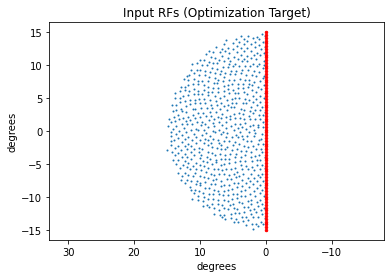

In [6]:
# generate prototypes on the visual field
if fov_shape in 'circle':
  x0 = generate_landmarks_spiral(0, ecc0, ecc1, n_prototypes, noise = prototype_noise)
elif fov_shape in 'square':
  x0 = generate_landmarks_square(square_height, n_prototypes)

x  = tf.constant(
        x0,
        dtype=tf.float64,
        name='x')

# generate prototypes on the boundary
bound0 = generate_v2_boundary(vm_len, map_h)
#b0 = generate_v2_boundary(boundary_len, map_h)
b = tf.constant(
    bound0,
    dtype=tf.float64,
    name='b')


#%matplotlib qt
## plot x0 (the visual field)
fig,axs = plt.subplots(1,1)
axs.scatter(x0[:,0],x0[:,1],s=1)
axs.axis('equal'); plt.xlabel('degrees'); plt.ylabel('degrees')
axs.set_title('Input RFs (Optimization Target)')
axs.invert_xaxis()
plt.scatter(bound0[:,0],bound0[:,1],s=6,color='red')
plt.show()


# Generate Initial Conditions 
Note that initially, there is no orderly azimuth or elevation map because the individual neuron pixels on the cortex are randomly assigned to one of the input RFs.

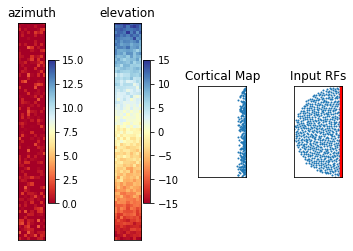

In [7]:
#choose vertical meridian or random initial mapping
if init=='random':
    y0 = initial_condition_random(map_h, map_w, x0)
else:
    y0 = initial_condition_vm(map_h, map_w, x0)


## plot y0 (the initial cortical map)
plot_output(y0,map_w,map_h,ecc1,x0,fov_shape);


# Define Cost-Function


In [8]:
# the weights of the regularization terms balanced against main cost
beta0 = tf.placeholder(tf.float64, shape=(), name="b0") #main cost
beta1 = tf.placeholder(tf.float64, shape=(), name="b1") #smoothness within area
beta2 = tf.placeholder(tf.float64, shape=(), name="b2") #boundary smoothness
beta3 = tf.placeholder(tf.float64, shape=(), name="b3") #even x,y gradients

# annealing parameter (essentially size of gaussian that 'pulls' cortical map to visual field, and reduces with iteration)
kappa = tf.placeholder(tf.float64, shape=(), name="k")

y = tf.get_variable(
        "y",
        dtype = tf.float64,
        initializer = y0)

# this is the boundary of the cortical map
yb = y[:map_h]

#### main cost (visual field)
yx_diff = tf.expand_dims(y, 1) - tf.expand_dims(x, 0) #matrix subtraction between cortex and target
yx_normsq = tf.einsum('ijk,ijk->ij', yx_diff, yx_diff)
yx_gauss = tf.exp(-1.0 * yx_normsq / (2.0 * kappa * kappa))
yx_cost =- 1.0 * kappa * tf.reduce_sum(
            tf.log(
                tf.reduce_sum(yx_gauss, axis=0)))

#### regularization term 1 - continuity within area
# n is a list of map_h * map_w objects.
#The i-th item s neighboring the i-th nodeof n is a list containing the indices of node
n = neighborhood(map_h, map_w)
mask = tf.constant(make_mask(map_h, map_w, n), dtype=tf.float64, name='mask')

# pairwise distance within the map: first use expand_dims to calculate pairwise difference
yy_diff = tf.expand_dims(y, 1) - tf.expand_dims(y, 0)
yy_normsq = tf.einsum('ijk,ijk->ij', yy_diff, yy_diff)
yy_normsq_masked = tf.multiply(mask, yy_normsq)#then only look at the diff among neighbors

reg1 = tf.reduce_sum(yy_normsq_masked)

#### regularization term 2 - impose boundary (continuity across boundary)
# pairwise distance between map and boundary
yb_diff = tf.expand_dims(yb, 1) - tf.expand_dims(b, 0)
yb_normsq = tf.einsum('ijk,ijk->ij', yb_diff, yb_diff)
bmask = make_boundary_mask(map_h)
yb_normsq_masked = tf.multiply(bmask, yb_normsq)

reg2 = tf.reduce_sum(yb_normsq_masked)

#### regularization term 3 - equal resolution along two axis of rectangular cortex
n_x = neighborhood_x(map_h, map_w)
n_y = neighborhood_y(map_h, map_w)
mask_x = tf.constant(make_mask(map_h, map_w, n_x), dtype=tf.float64, name='mask')
mask_y = tf.constant(make_mask(map_h, map_w, n_y), dtype=tf.float64, name='mask')
yy_normsq_masked_az = tf.multiply(mask_x, yy_normsq)
yy_normsq_masked_el = tf.multiply(mask_y, yy_normsq)

reg3=tf.abs(tf.reduce_sum(yy_normsq_masked_az)-tf.reduce_sum(yy_normsq_masked_el))

# Define Optimizer
Dfine a gradient descent algorithm to solve the minimization problem.

In [9]:
global_step = tf.Variable(0, trainable=False)
current_eta = tf.train.exponential_decay(eta0, global_step, 10, 0.99, staircase=False)

cost = beta0*yx_cost + beta1 * reg1 + beta2 * reg2 + beta3 *reg3
opt = tf.train.RMSPropOptimizer(current_eta, momentum = m).minimize(cost, global_step = global_step)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


# Run the Simulation
This will take a while but you can see that status of the model as it optimizes.

In [11]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

k=100
for i in range(num_iter):

    sess.run(opt, {kappa: k, beta0:b0, beta1: b1, beta2: b2, beta3: b3})
    #zz = sess.run(y)
    [zz,e1,e2,e3,e4] = sess.run([y,yx_cost, reg1, reg2, reg3], {kappa: k})

    #print the stat of the model for every 100th iteration
    if i%100==0:
        print (i, ":", k)

    #update annealing factor    
    if k>0.01:
        k = k - k*0.005



0 : 100
  419606.6193529  418954.6202066 16419.3055911 768.5955621 4545.4037253
100 : 60.5770436490728
  253755.9878763  253602.0429324 1198.7786838 2986.8461904 945.8732552
200 : 36.695782172616696
  153384.8258714  153172.4950409 1921.4933171 4954.0488408 202.1521934
300 : 22.229219984074696
  92358.9544658  92077.3886080 2402.3281804 6771.5230982 211.6773138
400 : 13.465804292601353
  54971.7825355  54643.3457513 2630.3944886 8032.4379090 285.0604076
500 : 8.157186144027845
  31574.3214485  31273.8962372 2156.5175767 7598.1132735 259.5428595
600 : 4.941382211003868
  17060.3335158  16863.5931081 1439.0107324 4787.3019078 331.7009517
700 : 2.9933432588273354
  8723.5815603  8531.2518434 3358.9250949 2648.1629242 403.9025418
800 : 1.8132788524664138
  4295.6366801  4076.1309453 5300.3690177 1634.3773085 382.1115031
900 : 1.0984307219379859
  2021.6669139  1780.2109999 5756.7156931 1095.1336995 1196.6810728
1000 : 0.6653968578831996
  854.4940089  647.3146776 5648.1876743 995.7459317 2

# Plot Final Maps

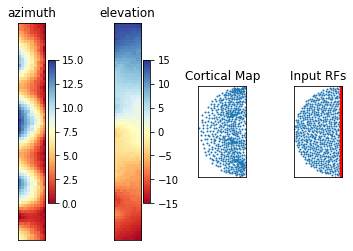

In [13]:
#plot the final state of the model
plot_output(zz,map_w,map_h,ecc1,x0,fov_shape);         